In [1]:
# Hacky way to import from parent directory
# https://www.reddit.com/r/learnpython/comments/x6nibz/comment/in7rxzu/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
import sys
sys.path.append('..')

In [3]:
from ebirdtools import EBirdTools
# San Jose
data_sj = EBirdTools.load_data('../data/ebd_2025-08-20-20-26-00_37.33_-121.86_30_50.csv').sample(frac=0.1)
# Everglades (Florida). This file is small so it's ok to load more.
data_eg = EBirdTools.load_data('../data/ebd_2025-08-20-20-31-45_25.75_-80.56_30_50.csv').sample(frac=0.5)
# Chicago
data_ch = EBirdTools.load_data('../data/ebd_2025-08-20-20-35-54_41.88_-87.63_30_50.csv').sample(frac=0.1)
# Los Angeles
data_la = EBirdTools.load_data('../data/ebd_2025-08-20-20-40-54_34.05_-118.24_30_50.csv').sample(frac=0.1)
# Seattle
data_se = EBirdTools.load_data('../data/ebd_2025-08-20-20-44-54_47.61_-122.33_30_50.csv').sample(frac=0.1)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px

In [5]:
def label_clusters(df, plot=False):
    """
    Returns a copy of the input df with a new column
    specifying which cluster each row belongs to.
    """
    clustering = KMeans(n_clusters=round(len(df) ** (1/3))).fit(df[['lat', 'lng']])
    
    df_aug = df.copy()
    df_aug['cluster'] = pd.Series(clustering.labels_, index=df_aug.index)
    
    if plot:
        fig = px.scatter_mapbox(df_aug, lat='lat', lon='lng', color='cluster', hover_name='comName')
        fig.update_mapboxes(style='open-street-map')
        fig.show()
    return df_aug

In [6]:
def species_per_cluster(df, by='comName'):
    """
    Takes a df and returns a dict:
        Key: Cluster number
        Val: set of names found in the cluster
    """
    species = {}
    for i in pd.unique(df['cluster']):
        names = set(df[df['cluster'] == i][by])
        species[i] = names
    return species

In [7]:
def get_similarity(df_a, df_b):
    """
    Gets cluster similarity by calculating the set
    similarity of the species names found in each cluster.
    """
    output = []
    sp_a = species_per_cluster(df_a)
    sp_b = species_per_cluster(df_b)
    for k_a, v_a in sp_a.items():
        for k_b, v_b in sp_b.items():
            iou = len(v_a.intersection(v_b)) / len(v_a.union(v_b))
            d = {'A': k_a, 'B': k_b, 'iou': iou}
            output.append(d)
    return pd.DataFrame(output)

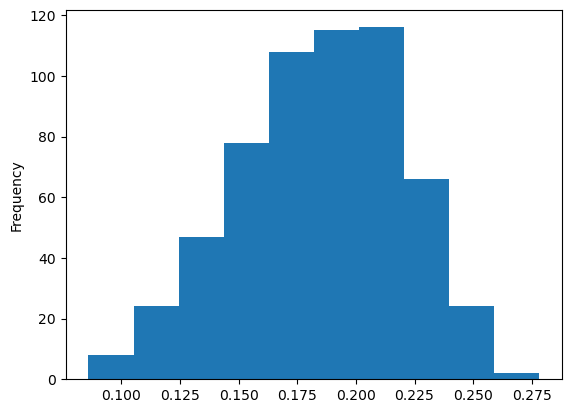

In [59]:
cluster_similarities = get_similarity(
    label_clusters(data_sj),
    label_clusters(data_ch)
)
_ = cluster_similarities['iou'].plot.hist()

In [129]:
def foo(name, df_src, df_tgt):
    if name not in df_src['comName'].values:
        raise KeyError('Unable to find species in the source location.')
    print('Is bird already found at the target location?', name in df_tgt['comName'].values)
    
    df_src = label_clusters(df_src)
    df_tgt = label_clusters(df_tgt)
    # find which source clusters the named species occurs in
    src_clusters = np.unique(df_src[df_src['comName'] == name]['cluster'])
    # drop the clusters that the named species doesn't occur in
    df_src = df_src[df_src['cluster'].isin(src_clusters)]
    # compare species sets
    sims = get_similarity(df_src, df_tgt)
    
    s_mean = sims['iou'].mean()
    s_std = sims['iou'].std()
    s_max = sims['iou'].max()
    z = (s_max - s_mean) / s_std
    a = sims[sims['iou'] == s_max]['A'].item()
    b = sims[sims['iou'] == s_max]['B'].item()
    print('Sub-cluster compatability:', round(s_mean, 2))
    print('Highest similarity:', round(s_max, 2), f'(z {round(z, 2)})')
    print('Source cluster:', a)
    print('Target cluster:', b)
    
    return sims

In [153]:
sims = foo("Western Bluebird", data_la, data_sj)

Is bird already found at the target location? True
Sub-cluster compatability: 0.33
Highest similarity: 0.57 (z 3.08)
Source cluster: 5
Target cluster: 27


In [135]:
sims = foo("Common Murre", data_sj, data_eg)

Is bird already found at the target location? False
Sub-cluster compatability: 0.09
Highest similarity: 0.17 (z 1.79)
Source cluster: 2
Target cluster: 13


In [151]:
sims = foo("Canada Goose", data_se, data_ch)

Is bird already found at the target location? True
Sub-cluster compatability: 0.24
Highest similarity: 0.35 (z 2.82)
Source cluster: 21
Target cluster: 15
